In [1]:
#melakukan import module
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import fastf1
import fastf1.plotting
import math
import datetime
from datetime import timedelta
import matplotlib as mpl

from matplotlib.collections import LineCollection
from adjustText import adjust_text

import geopandas as gpd

fastf1.plotting.setup_mpl()

<H1> <strong>Analisis Chinese GP 2024</strong></H1>

<H5>Dengan Safety Car yang sangat lama, balapan ini jadi balapan yang berbeda antara sebelum dan sesudah Safety Car. Seperti apa analisisnya?</H5>

In [8]:
#mendefinisikan fungsi pembantu

def getDuration(x): #mendapatkan durasi dari poin A ke B
    """
    Mendapatkan durasi dari Series waktu
    :param x: Series waktu
    :return: Skalar durasi waktu
    """
    min=x.min()
    max=x.max()
    return max-min


def rotate_matrix (x, y, angle, x_shift=0, y_shift=0, units="DEGREES"): #melakukan proses rotasi matriks numpy
    """
    Rotates a point in the xy-plane counterclockwise through an angle about the origin
    https://en.wikipedia.org/wiki/Rotation_matrix
    :param x: x coordinate
    :param y: y coordinate
    :param x_shift: x-axis shift from origin (0, 0)
    :param y_shift: y-axis shift from origin (0, 0)
    :param angle: The rotation angle in degrees
    :param units: DEGREES (default) or RADIANS
    :return: Tuple of rotated x and y
    """

    # Shift to origin (0,0)
    x = x - x_shift
    y = y - y_shift

    # Convert degrees to radians
    if units == "DEGREES":
        angle = math.radians(angle)

    # Rotation matrix multiplication to get rotated x & y
    xr = (x * math.cos(angle)) - (y * math.sin(angle)) + x_shift
    yr = (x * math.sin(angle)) + (y * math.cos(angle)) + y_shift

    return xr, yr

def rotate(xy, *, angle): #melakukan proses rotasi matriks numpy
    rot_mat = np.array([[np.cos(angle), np.sin(angle)],
                        [-np.sin(angle), np.cos(angle)]])
    return np.matmul(xy, rot_mat)

In [2]:
#mendapatkan data
china2024_r=fastf1.get_session(2024,'china','r')
china2024_r.load()

req         WARNING 	DEFAULT CACHE ENABLED! (784.82 MB) /Users/nendra/Library/Caches/fastf1
core           INFO 	Loading data for Chinese Grand Prix - Race [v3.3.1]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track st

In [3]:
#mengambil telemetri
laps_corrected=pd.DataFrame()
for drv in china2024_r.drivers:
    df=(china2024_r.laps.pick_driver(drv)['LapNumber']-1)*(101/china2024_r.total_laps)*35

    df[:]=df[::-1]
    df=df.apply(lambda x: timedelta(milliseconds=x))


    laps=pd.DataFrame(china2024_r.laps.pick_driver(drv))
    laps['fuel_corrected_laptime']=(laps['LapTime'])-df
    
    laps_corrected=pd.concat([laps_corrected,laps])

<p>

<H4><strong>Norris berhasil mempertahankan ban mediumnya hingga akhir sehingga memaksimalkan strategi 1 pit stop</strong></H4>

/var/folders/zk/r760srvd3r16_9wrdyh4d82w0000gn/T/ipykernel_55033/2273035730.py:8: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  tyreAlphas=pd.concat([tyreAlphas,(alphas-(alphas.min()-2))/(alphas.max()-(alphas.min()-2))])


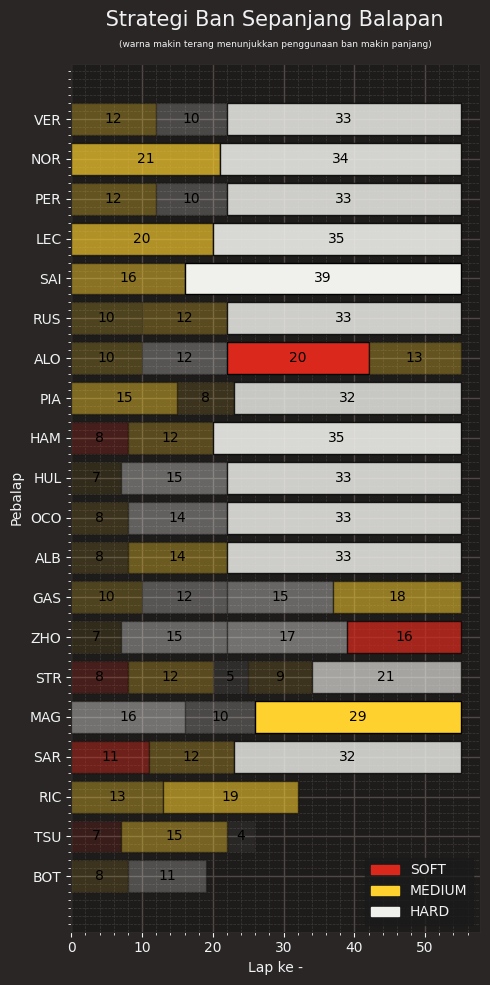

In [5]:
#menghitung data penggunaan ban
chinagp_tyre=laps_corrected[['Driver','DriverNumber','LapNumber','Compound','TyreLife','Stint','FreshTyre']]
chinagp_tyre=chinagp_tyre.drop(chinagp_tyre[chinagp_tyre['LapNumber']<2].index)
chinagp_tyre=chinagp_tyre.groupby(['Driver','DriverNumber','Compound','Stint','FreshTyre']).agg({'LapNumber':'count','TyreLife':'max'}).sort_values(by=['Driver','DriverNumber','Stint']).reset_index()
tyregroup=chinagp_tyre[['Driver','Compound','TyreLife']].groupby('Compound')
tyreAlphas=pd.Series()
for i,group in tyregroup:
    alphas=group['TyreLife']
    tyreAlphas=pd.concat([tyreAlphas,(alphas-(alphas.min()-2))/(alphas.max()-(alphas.min()-2))])
chinagp_tyre=chinagp_tyre.merge(pd.DataFrame(tyreAlphas),left_index=True,right_index=True).rename(columns={0:'alpha'})
fig,ax=plt.subplots(figsize=(5,10))
for driver in china2024_r.drivers:
    driver_stints = chinagp_tyre.loc[chinagp_tyre["DriverNumber"] == driver]

    previous_stint_end = 0
    for idx, row in driver_stints.iterrows():
        # each row contains the compound name and stint length
        # we can use these information to draw horizontal bars

        bars=ax.barh(
            y=row['Driver'],
            width=row["LapNumber"],
            left=previous_stint_end,
            color=fastf1.plotting.COMPOUND_COLORS[row["Compound"]],
            edgecolor="black",
            fill=True,
            label=row['Compound'],
            alpha=row['alpha']
        )
        
        ax.bar_label(bars, label_type='center', color='black')
        
        previous_stint_end += row["LapNumber"]

ax.invert_yaxis()
tyres=pd.DataFrame(fastf1.plotting.COMPOUND_COLORS,index=[0]).T.reset_index(names='Compound')
tyresLegend=tyres[tyres['Compound'].isin(chinagp_tyre['Compound'])]
colors = tyresLegend.set_index('Compound').to_dict()[0]
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
ax.legend(handles, labels)

ax.set_xlabel('Lap ke -')
ax.set_ylabel('Pebalap')

fig.suptitle('         Strategi Ban Sepanjang Balapan',fontsize=15)
ax.set_title('(warna makin terang menunjukkan penggunaan ban makin panjang)',fontsize=6.5)
fig.tight_layout()
#fig.legend(driver_stints['Compound'].unique())
plt.show()

<ul>
<li>Norris memiliki keuntungan yang sama dengan Ferrari (terutama Sainz). Dimana mereka memiliki kekuatan utamanya berupa degradasi ban yang sangat rendah, sehingga dapat melakukan 1 stop strategy saja.</li>

<li>Dengan menjaga pace dan ban medium di stint pertama, Norris dapat menjaga kedudukannya di depan Perez sebelum Safety Car pertama</li>
</ul>

<p>

<H4><strong>Setelah mengalami kerusakan Diffuser akibat tabrakan berantai Stroll-Ricciardo, Piastri tidak dapat memaksimalkan kecepatan mobilnya</strong></H4>


core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core      

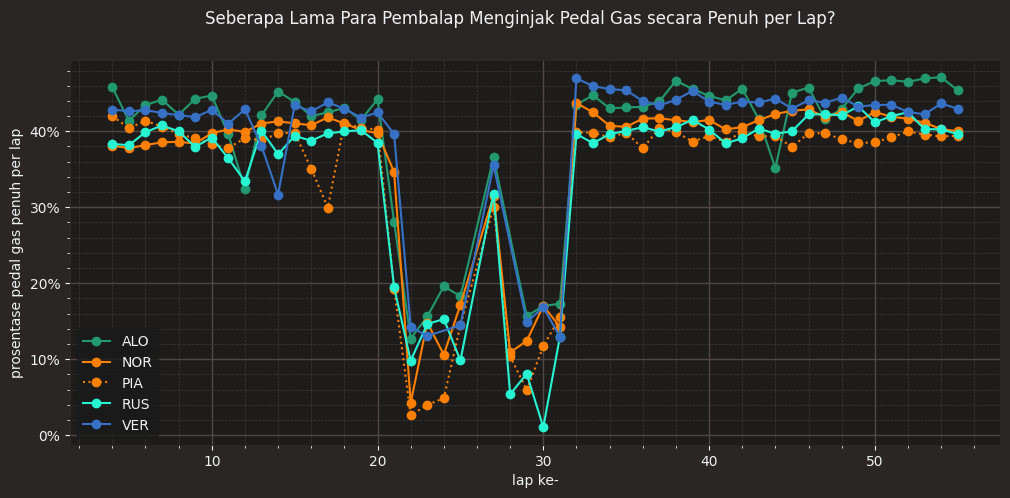

In [9]:
#menghitung durasi lama tancap gas
lap=[]
drivers=[]
throttleDuration=[]
for driver in china2024_r.drivers:
    for laps in range(2,china2024_r.total_laps):
        drivers.append(china2024_r.get_driver(driver).Abbreviation)
        lap.append(laps)
        try:
            test=pd.DataFrame(china2024_r.laps.pick_driver(driver).pick_lap(laps).get_telemetry())[['Throttle','Time']]
        except:
            throttleDuration.append(None)
            continue
        
        index=0
        isFullThrottle=[]
        for i,row in test.iterrows():
            if i==2 and row['Throttle']>=98:
                index+=1
                isFullThrottle.append(index)
            elif i==1 and row['Throttle']>=98:
                index+=1
                isFullThrottle.append(index)
            elif row['Throttle']>=98 and test['Throttle'][i-1]<98:
                index+=1
                isFullThrottle.append(index)
            elif row['Throttle']>=98:
                isFullThrottle.append(index)
            else:
                isFullThrottle.append(None)

        test['fullThrottleIndex']=isFullThrottle
        test_group=test.groupby('fullThrottleIndex')
        total_time=datetime.timedelta()
        for i,group in test_group:
            total_time+=getDuration(group['Time'])
        throttleDuration.append(total_time)
test_dic=zip(lap,drivers,throttleDuration)
dfThrottle=pd.DataFrame(list(test_dic)).rename(columns={0:'LapNumber',1:'Driver',2:'FullThrottleDuration'}) 
dfThrottle['tc']=dfThrottle['Driver'].apply(lambda x: '#'+china2024_r.get_driver(x).TeamColor)
dfThrottle=dfThrottle.merge(china2024_r.laps[['LapTime','LapNumber','Driver']], on=['LapNumber','Driver']).dropna()
dfThrottle['PercentFullThrottle']=(dfThrottle['FullThrottleDuration']/dfThrottle['LapTime'])*100 

fig,ax=plt.subplots(figsize=(12,5))
#sns.lineplot(data=dfThrottle,x='LapNumber',y='FullThrottleDuration',hue='Driver',ax=ax,marker='o')
pits=china2024_r.laps.pick_drivers(['NOR','PIA','VER','RUS','ALO']).dropna(subset='PitInTime')[china2024_r.laps['LapNumber']>1][['Driver','DriverNumber','LapNumber']]
tcCache=[]
dfThrottleViz=dfThrottle[(dfThrottle['LapNumber']>=4) & (dfThrottle['Driver'].isin(['NOR','PIA','VER','RUS','ALO']))]
for i,group in dfThrottleViz.groupby(['Driver','tc']):
    if i[1] in tcCache:
        linestyleVar=':'
    else:
        linestyleVar='-'
    tcCache.append(i[1])
    ax.plot(group['LapNumber'],group['PercentFullThrottle'],color=i[1],label=i[0],marker='o',linestyle=linestyleVar)


from matplotlib.ticker import PercentFormatter
fig.suptitle('Seberapa Lama Para Pembalap Menginjak Pedal Gas secara Penuh per Lap?')
ax.yaxis.set_major_formatter(PercentFormatter())
ax.set_ylabel('prosentase pedal gas penuh per lap')
ax.set_xlabel('lap ke-')

ax.legend()


<ul>
<li>Dalam tabrakan beruntun yang disebabkan oleh Stroll, Ricciardo juga "menyundul" Piastri dan menyebabkan Diffuser milik Piastri rusak</li>
<li>Dengan tidak adanya Diffuser, maka Piastri akan kesulitan melewati tikungan - tikungan berkecepatan tinggi karena kurangnya downforce. Hal ini ditunjukkan dengan berkurangnya tingkan "gaspol" Piastri setelah SC</li>

<li>Alonso juga lebih "gaspol" saat berganti ke ban medium di stint terakhir, dibandingkan saat menggunakan ban soft pada stint sebelumnya</li>
</ul>

<p>

<H4><strong>Norris lebih cepat dari Perez setelah SC, tetapi Verstappen jauh di depan mereka</H3></strong>


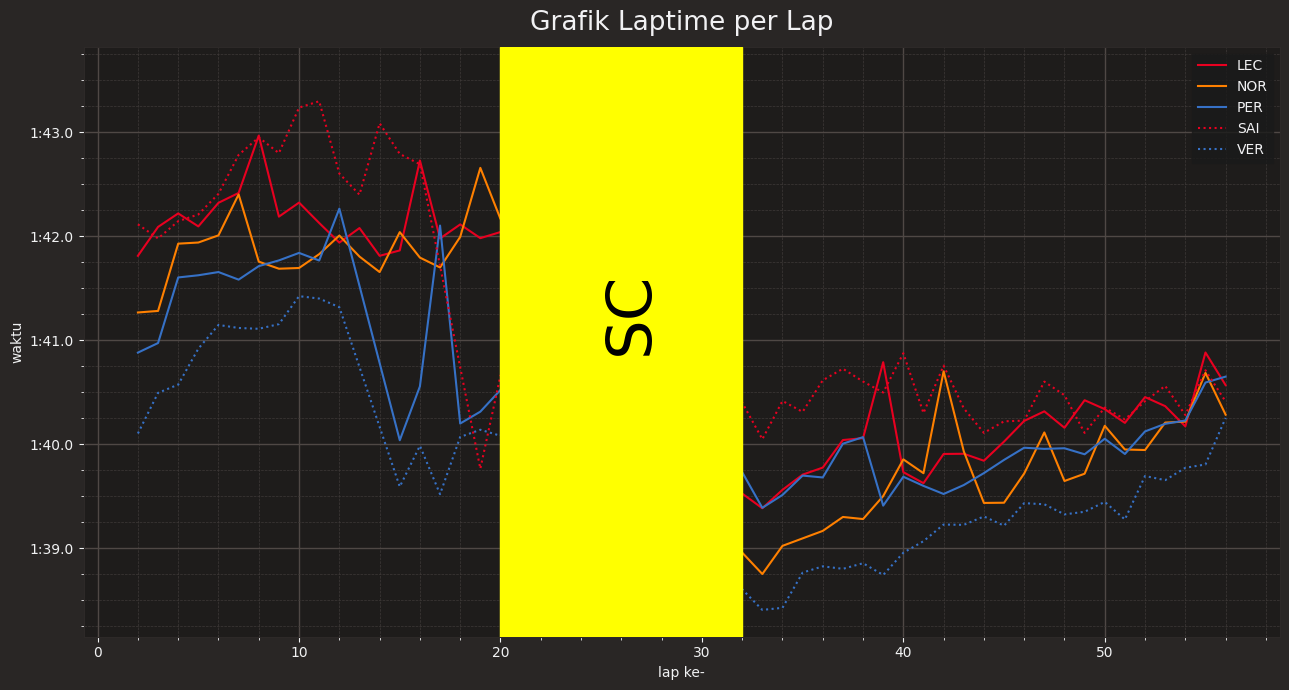

In [ ]:
#menampilkan line chart pace VER,PER,LEC,SAI,NOR
laps_corrected_lim=laps_corrected[(laps_corrected['LapTime']<datetime.timedelta(minutes=1,seconds=45))&(laps_corrected['LapNumber']>1)]
fig,axs=plt.subplots(figsize=(13,7))
cacheTeam=[]
for index,group in laps_corrected_lim[laps_corrected_lim['Driver'].isin(['NOR','VER','PER','SAI','LEC'])][['LapTime','LapNumber','Driver','DriverNumber','Team']].groupby(['Driver','DriverNumber','Team']):
    if index[2] in cacheTeam:
        linestyleVar=':'
    else:
        linestyleVar='-'
        cacheTeam.append(index[2])
    
    #X_Y_Spline = make_interp_spline(group['LapNumber'], group['LapTime'])
    #X_ = np.linspace(group['LapNumber'].min(), group['LapNumber'].max(), 500)
    #Y_ = X_Y_Spline(X_)
    axs.plot(group['LapNumber'], group['LapTime'],color='#'+china2024_r.get_driver(index[1]).TeamColor,linestyle=linestyleVar,label=index[0])
#sns.lineplot(data=laps_corrected_lim[laps_corrected_lim['LapNumber']>3],y='LapTime',x='LapNumber',hue='Driver',ax=axs[1],palette=teamsColor)
#axs[1].set_ylim(0.00107,0.00116)
#fig.suptitle('Konsistensi Pace')
axs.axvspan(20, 32, color='yellow',zorder=3)
ymin,ymax=axs.get_ylim()
axs.text(((30-20)/2)+20,((ymax-ymin)/2)+ymin,'SC',c='black',rotation=90,horizontalalignment='left',fontsize=45)
axs.set_title('Grafik Laptime per Lap')
axs.set_ylabel('waktu')

axs.set_ylabel('waktu')
axs.set_xlabel('lap ke-')

axs.legend()
fig.tight_layout()


<p>Sebelum SC, Perez sebenarnya memiliki pace yang lebih cepat dibanding Norris, namun setelahnya Norris memiliki pace yang lebih cepat dibanding Perez, bahkan kedua Ferrari. Tapi Verstappen memang sangat cepat sehingga tidak tersentuh sekalipun</p>

<p>

<H4><strong>Piastri melambat setelah kerusakan Diffuser, Alonso meroket setelah ganti ke ban medium di stint terakhir</strong></H4>

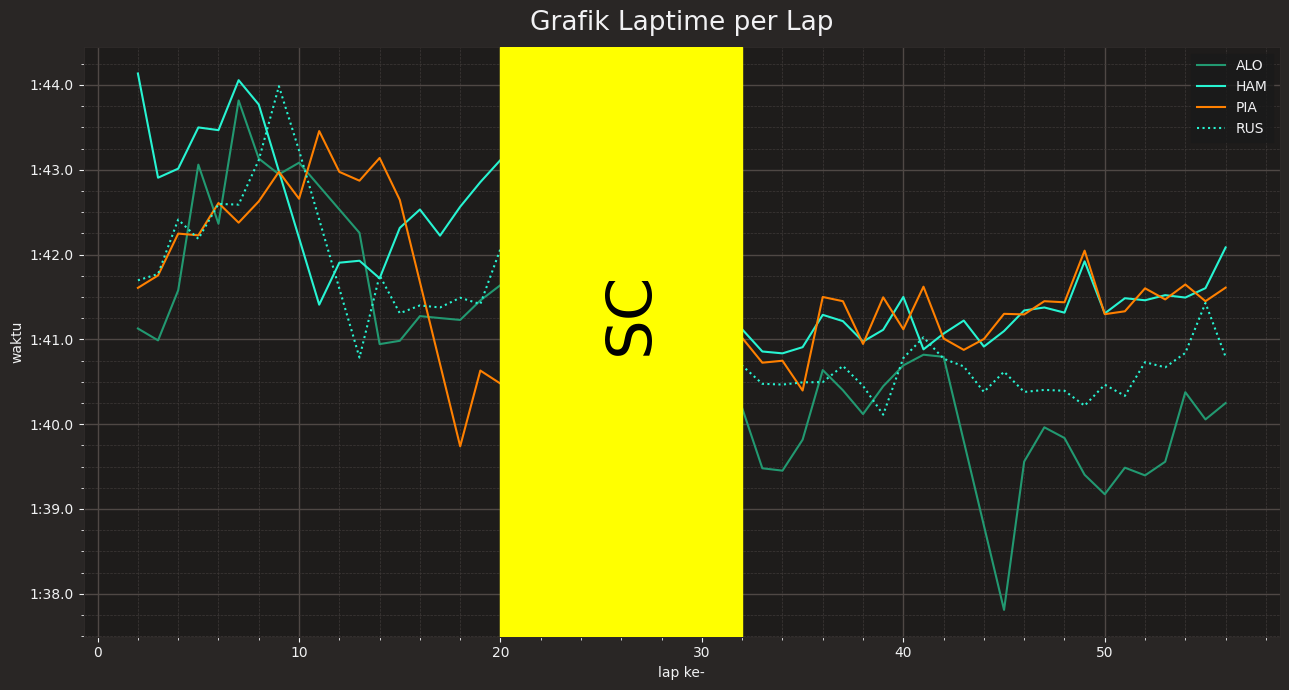

In [ ]:
#menampilkan line chart pace ALO,HAM,PIA,RUS
laps_corrected_lim=laps_corrected[(laps_corrected['LapTime']<datetime.timedelta(minutes=1,seconds=45))&(laps_corrected['LapNumber']>1)]
fig,axs=plt.subplots(figsize=(13,7))
cacheTeam=[]
for index,group in laps_corrected_lim[laps_corrected_lim['Driver'].isin(['PIA','RUS','ALO','HAM'])][['LapTime','LapNumber','Driver','DriverNumber','Team']].groupby(['Driver','DriverNumber','Team']):
    if index[2] in cacheTeam:
        linestyleVar=':'
    else:
        linestyleVar='-'
        cacheTeam.append(index[2])
    
    #X_Y_Spline = make_interp_spline(group['LapNumber'], group['LapTime'])
    #X_ = np.linspace(group['LapNumber'].min(), group['LapNumber'].max(), 500)
    #Y_ = X_Y_Spline(X_)
    axs.plot(group['LapNumber'], group['LapTime'],color='#'+china2024_r.get_driver(index[1]).TeamColor,linestyle=linestyleVar,label=index[0])
#sns.lineplot(data=laps_corrected_lim[laps_corrected_lim['LapNumber']>3],y='LapTime',x='LapNumber',hue='Driver',ax=axs[1],palette=teamsColor)
#axs[1].set_ylim(0.00107,0.00116)
#fig.suptitle('Konsistensi Pace')
axs.axvspan(20, 32, color='yellow',zorder=3)
ymin,ymax=axs.get_ylim()
axs.text(((30-20)/2)+20,((ymax-ymin)/2)+ymin,'SC',c='black',rotation=90,horizontalalignment='left',fontsize=45)
axs.set_title('Grafik Laptime per Lap')
axs.set_ylabel('waktu')

axs.set_ylabel('waktu')
axs.set_xlabel('lap ke-')

axs.legend()
fig.tight_layout()

<ul>
<li>
Sebelum SC, Piastri memiliki pace yang lebih cepat (~73%) dibanding Alonso dan Russell, meskipun memang ada beberapa lap yang lemah juga</li>

<li>Namun karena ada kerusakan, Piastri akhirnya dapat disalip oleh Russell dan Alonso yang sangat cepat saat stint terakhir. Hamilton memiliki pace yang mirip dengan Piastri</li>

<p>

<H4><strong>Aston Martin mendominasi setiap segmen trek berkecepatan tinggi</strong></H4>



In [ ]:
#mendapatkan semua telemetri untuk lap dengan ban MEDIUM dan HARD
drvLaps=china2024_r.laps[['DriverNumber','LapNumber']].groupby('DriverNumber').max()
all_race=pd.DataFrame()
for drv in china2024_r.drivers:
    laps=china2024_r.laps.pick_driver(drv).pick_compounds(['HARD','MEDIUM'])
    
    for i in range(1,int(drvLaps[drvLaps.index==drv]['LapNumber'].iloc[0])):
        try:
            df_temp=pd.DataFrame(laps.pick_lap(i).pick_accurate().pick_wo_box().get_telemetry())
            df_temp['drvName']=china2024_r.get_driver(drv).Abbreviation
            df_temp['teamName']=china2024_r.get_driver(drv).TeamName
            df_temp['teamColor']='#'+china2024_r.get_driver(drv).TeamColor
            df_temp['LapNumber']=i
            all_race=pd.concat([all_race,df_temp])
        except:
            continue

core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core      

In [ ]:
#mengimpor segmen custom
poi=gpd.read_file(r'../../data/raw/shanghai_poi.geojson')

all_race_geom=all_race.copy()
all_race_geom['geometry']=gpd.points_from_xy(all_race_geom.X, all_race_geom.Y, crs='epsg:4326')

all_race_geom=gpd.GeoDataFrame(all_race_geom)

all_race_geom.set_geometry('geometry',inplace=True)

all_race_geom=gpd.sjoin_nearest(all_race_geom,poi[['AUTO','geometry']],how='inner',distance_col='distance').rename(columns={'AUTO':'miniSect'})
def grSectOne(x):
    if x>timedelta(minutes=1):
        return 'b'
    else:
        return 'a'
all_race_geom['group']=all_race_geom['Time'].apply(lambda x: grSectOne(x))
data=[]

for i,group in all_race_geom[['miniSect','drvName','Time','LapNumber','group','teamColor']].groupby(['drvName','LapNumber','miniSect','teamColor']):
    #print(i)
    if i[2]==1:
        time=group.groupby(['drvName','miniSect','LapNumber','teamColor','group']).agg(getDuration).sum().iloc[0]
        
    else:
        time=getDuration(group['Time'])
        

    data.append(i+(time,))
first_set=pd.DataFrame(data,columns=['drvName','LapNumber','miniSect','teamColor','Time'])
#all_race['miniSect']=(np.round(all_race['RelativeDistance'].to_numpy()/(1/20))+1).astype(int)

theoretical_best_minisectors=first_set[['drvName','Time','miniSect','teamColor']].groupby(['drvName','miniSect','teamColor']).min().reset_index()
sum_tbest_minisectors=theoretical_best_minisectors.groupby('drvName').agg(IdealmSTime=('Time','sum'))
dfTime=theoretical_best_minisectors.sort_values('Time',ascending=False).drop_duplicates(subset='miniSect', keep='last').sort_values('miniSect').reset_index(drop=True)

listProp=dfTime[['drvName','teamColor']].value_counts(['drvName','teamColor'],normalize=True).reset_index()

single_lap = pd.DataFrame(china2024_r.laps.pick_driver('PER').pick_fastest().get_telemetry())[['X','Y','RelativeDistance']]

single_lap['geometry']=gpd.points_from_xy(single_lap.X, single_lap.Y, crs='epsg:4326')
single_lap=gpd.GeoDataFrame(single_lap)
single_lap.set_geometry('geometry',inplace=True)

single_lap=gpd.sjoin_nearest(single_lap,poi[['AUTO','geometry']],how='inner',distance_col='distance',max_distance=3).rename(columns={'AUTO':'miniSect'})
#single_lap['miniSect']=single_lap['RelativeDistance'].apply(lambda x: int(x/(1/20))+1)
single_lap=single_lap.merge(dfTime,on='miniSect')
single_lap=single_lap.merge(single_lap[['drvName']].drop_duplicates().reset_index(drop=True).reset_index().rename(columns={'index':'id'}),on='drvName')#id dari 0
single_lap['tc']=single_lap['drvName'].apply(lambda x:'#'+china2024_r.get_driver(x).TeamColor)
single_lap=single_lap.merge(single_lap[['tc']].drop_duplicates().reset_index(drop=True).reset_index().rename(columns={'index':'idTeam'}),on='tc')#id dari 0

f:\f1analytics\.venv\lib\site-packages\geopandas\array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
f:\f1analytics\.venv\lib\site-packages\geopandas\array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [ ]:
#menghitung SPEED DOMINANCE per segmen track (segmen kustom)
chinagp_telem=pd.DataFrame()
for drv in china2024_r.drivers:
    try:
        tmp_df=pd.DataFrame(china2024_r.laps.pick_driver(drv).pick_fastest().get_telemetry())
    except:
        continue
    tmp_df['drvNum']=float(china2024_r.get_driver(drv).DriverNumber)
    tmp_df['tc']='#'+china2024_r.get_driver(drv).TeamColor
    tmp_df['drv']=china2024_r.get_driver(drv).Abbreviation
    chinagp_telem=pd.concat([chinagp_telem,tmp_df])
chinagp_telem=all_race
#alorus_telem=alorus_telem.query("DRS in [0,1,2,3,8]")
chinagp_telem['geometry']=gpd.points_from_xy(chinagp_telem.X, chinagp_telem.Y, crs="EPSG:4326")
chinagp_telem=gpd.GeoDataFrame(chinagp_telem)
chinagp_telem.set_geometry('geometry',inplace=True)
chinagp_telem=gpd.sjoin_nearest(chinagp_telem,gpd.read_file(r'../../data/raw/shanghai_poi.geojson')[['AUTO','geometry']],how='left').rename(columns={'AUTO':'miniSect'})
#chinagp_telem.loc[:,'miniSect']=np.round(chinagp_telem['RelativeDistance'].to_numpy()/(1/20))+1

chinagp_speed=chinagp_telem[['Speed','miniSect','drvName','teamColor']]

dfSpeed=chinagp_speed.sort_values('Speed').drop_duplicates(subset='miniSect', keep='last').sort_values('miniSect').reset_index(drop=True)
listProp=dfSpeed[['drvName','teamColor']].value_counts(['drvName','teamColor'],normalize=True).reset_index()

single_lap = pd.DataFrame(china2024_r.laps.pick_driver('PER').pick_fastest().get_telemetry())[['X','Y','RelativeDistance']]
single_lap['geometry']=gpd.points_from_xy(single_lap.X, single_lap.Y, crs="EPSG:4326")
single_lap=gpd.GeoDataFrame(single_lap)
single_lap.set_geometry('geometry',inplace=True)
single_lap=gpd.sjoin_nearest(single_lap,gpd.read_file(r'../../data/raw/shanghai_poi.geojson')[['AUTO','geometry']],how='left').rename(columns={'AUTO':'miniSect'})
#single_lap['miniSect']=single_lap['RelativeDistance'].apply(lambda x: int(x/(1/20))+1)
single_lap=single_lap.merge(dfSpeed,on='miniSect')
single_lap=single_lap.merge(single_lap[['drvName']].drop_duplicates().reset_index(drop=True).reset_index().rename(columns={'index':'id'}),on='drvName')#id dari 0
single_lap['teamColor']=single_lap['drvName'].apply(lambda x:'#'+china2024_r.get_driver(x).TeamColor)
single_lap=single_lap.merge(single_lap[['teamColor']].drop_duplicates().reset_index(drop=True).reset_index().rename(columns={'index':'idTeam'}),on='teamColor')#id dari 0

circuit_info = china2024_r.get_circuit_info()

core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core      

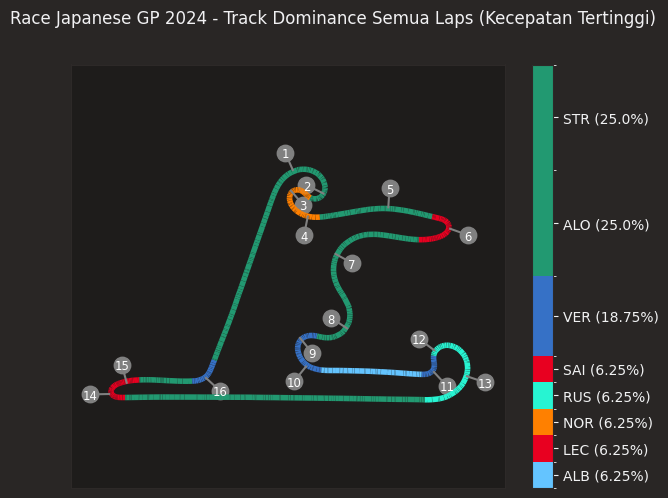

In [ ]:
#menampilkan visualisasi track
from matplotlib.colors import BoundaryNorm, ListedColormap
circRot=circuit_info.rotation
x,y=rotate_matrix(single_lap['X'].values,single_lap['Y'].values,circRot)


listProp.sort_values('proportion',inplace=True)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
fastest_avg=single_lap['idTeam'].to_numpy().astype(float)

#teamColor=single_lap[['id','tc']].drop_duplicates()
cmap = ListedColormap(single_lap['teamColor'].drop_duplicates().to_list())
lc_comp = LineCollection(segments, norm=plt.Normalize(0, cmap.N), cmap=cmap)
lc_comp.set_array(fastest_avg)
lc_comp.set_linewidth(4)


fig,ax=plt.subplots(figsize=(7,5.5))
    

fig.suptitle(
        f"Race Japanese GP 2024 - Track Dominance Semua Laps (Kecepatan Tertinggi)"
    )
        
ax.add_collection(lc_comp)
ax.axis('equal')
ax.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)

offset_vector = [700, 0] 
# Iterate over all corners.
for _, corner in circuit_info.corners.iterrows():
    # Create a string from corner number and letter
    txt = f"{corner['Number']}{corner['Letter']}"

    # Convert the angle from degrees to radian.
    offset_angle = corner['Angle'] / 180 * np.pi

    # Rotate the offset vector so that it points sideways from the track.
    offset_x, offset_y = rotate(offset_vector, angle=offset_angle)

    # Add the offset to the position of the corner
    text_x = corner['X'] + offset_x
    text_y = corner['Y'] + offset_y

    # Rotate the text position equivalently to the rest of the track map
    text_x, text_y = rotate([text_x, text_y], angle=math.radians(circRot))

    # Rotate the center of the corner equivalently to the rest of the track map
    track_x, track_y = rotate([corner['X'], corner['Y']], angle=math.radians(circRot))

    # Draw a circle next to the track.
    plt.scatter(text_x, text_y, color='grey', s=140)

    # Draw a line from the track to this circle.
    plt.plot([track_x, text_x], [track_y, text_y], color='grey')
    

    # Finally, print the corner number inside the circle.
    plt.text(text_x, text_y, txt,
             va='center_baseline', ha='center', size='small', color='white')
#plt.arrow(x[0],y[0]+300,+900,0,color='white',shape='right',head_width=500)
bounds=[i*10 for i in(listProp.sort_values('proportion')['proportion'].to_list())]
bounds.insert(0,0)
boundsx=[]
mem=0
for i in bounds:
    i+=mem
    mem=i
    boundsx.append(i)


cmap = ListedColormap(listProp['teamColor'].to_list())
norm = BoundaryNorm(boundsx, cmap.N)

cbar=fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm),ax=ax,spacing='proportional')
initial=0
ticksList=[]
for i in listProp['proportion']:
    if i!=0:
        ticksList.append((((i*10)/2)+initial))
        initial+=i*10

cbar.set_ticks(ticksList)
#listProp['bounds']=boundsx
labels=[]
for j,k in listProp.iterrows():
    label=f'{k["drvName"]} ({round(k["proportion"]*100,2)}%)'
    labels.append(label)

cbar.set_ticklabels(labels)#ambil driver name dari variabel!!!
plt.xticks([])
plt.yticks([])
plt.show()

<ul>
<li>
Aston Martin menguasai segmen trek lurus dan tikungan berkecepatan tinggi, dan masing-masing pembalap mendominasi dengan seimbang. Meskipun ada satu segmen trek lurus yang dikuasai oleh Albon
</li>
<li>
Ferrari mendominasi pada tikungan - tikungan hairpin seperti tikungan 6 dan tikungan 14, tetapi Lando menguasai hairpin tikungan 3
</li>
<li>
Verstappen menguasai tiap tikungan semi cepat (berbentuk 'L'), yang berarti Verstappen pandai memanfaatkan track space tanpa melewati track limit.
</li>
</ul>

<p>

<H4><strong>Setting Downforce yang rendah mengurangi tingkat degradasi ban</strong></H4>



In [ ]:
#mengisolasi dataframe DRS
drsSpeed=all_race[['drvName','teamName','teamColor','DRS','Speed','DistanceToDriverAhead','Throttle','Brake']]

no_drs=drsSpeed[(drsSpeed['DRS'].isin([0,1,8]))&(drsSpeed['Throttle']>98)&(drsSpeed['Brake']==0)]
no_drs_slipstream=no_drs[no_drs['DistanceToDriverAhead']<5]
no_drs_no_slipstream=no_drs[no_drs['DistanceToDriverAhead']>5]

with_drs=drsSpeed[~drsSpeed['DRS'].isin([0,1,2,3,8])]
drs_slipstream=with_drs[with_drs['DistanceToDriverAhead']<5]
drs_no_slipstream=with_drs[with_drs['DistanceToDriverAhead']>5]
no_drs.drop([646,653,644,643,642,666,641,651,630,637,636],inplace=True)

C:\Users\haryo\AppData\Local\Temp\ipykernel_48796\813827883.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_drs.drop([646,653,644,643,642,666,641,651,630,637,636],inplace=True)


In [ ]:
#mendapatkan kecepatan tertinggi
maxspeed_no_drs=no_drs[['drvName','teamName','teamColor','Speed']].groupby(['drvName','teamName','teamColor']).max()
maxspeed_drs=with_drs[['drvName','teamName','teamColor','Speed']].groupby(['drvName','teamName','teamColor']).max()


In [ ]:
#menghitung kecepatan yang didapatkan
result=maxspeed_drs-maxspeed_no_drs
result.rename(columns=({'Speed':'SpeedGain'}),inplace=True)
result['SpeedGainStr']='+'+result['SpeedGain'].astype(str)
maxspeed_drs.merge(result,on='drvName')

,Speed,SpeedGain,SpeedGainStr
drvName,,,
ALB,338,18,+18
ALO,336,23,+23
BOT,342,13,+13
GAS,339,28,+28
HAM,337,21,+21
HUL,340,21,+21
LEC,336,10,+10
MAG,346,27,+27
NOR,332,18,+18


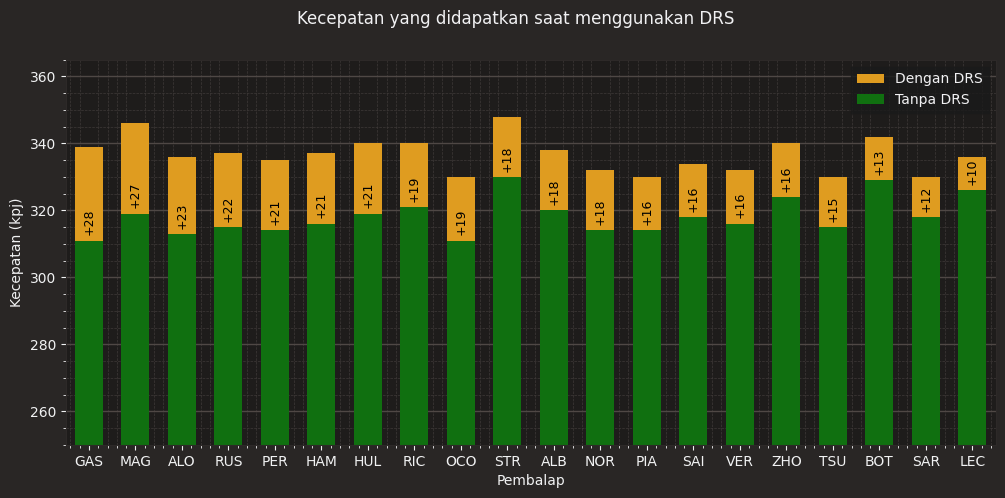

In [ ]:
#menampilkan visualisasi DRS
teamsColor={row['teamName']:row['teamColor'] for i,row in drsSpeed[['teamName','teamColor']].drop_duplicates().iterrows()} 
maxspeed_no_drs.sort_values('Speed',inplace=True,ascending=False)
fig,ax=plt.subplots(figsize=(12,5))

sns.barplot(data=maxspeed_drs,x='drvName',y='Speed',color='orange',ax=ax,label='Dengan DRS',order=result.sort_values('SpeedGain',ascending=False).reset_index()['drvName'],width=0.6)


sns.barplot(data=maxspeed_no_drs,x='drvName',y='Speed',ax=ax,color='green', label='Tanpa DRS',order=result.sort_values('SpeedGain',ascending=False).reset_index()['drvName'],width=0.6)
ax.bar_label(ax.containers[1], labels=result.sort_values('SpeedGain',ascending=False)['SpeedGainStr'],fontsize=9,rotation=90,padding=4,color='black')
ax.set_xlabel('Pembalap')
ax.set_ylabel('Kecepatan (kpj)')

ax.set_ylim(250,365)
fig.suptitle('Kecepatan yang didapatkan saat menggunakan DRS')
plt.show()

<ul>
<li>
Setting Downforce pada sayap belakang dapat dilihat pada seberapa besar pertambahan kecepatan saat DRS diaktifkan. Semakin besar pertambahan kecepatan oleh DRS, maka setting Downforce sayap belakang juga semakin besar
</li>

<li>
Setting Downforce juga berkorelasi positif dengan degradasi ban, artinya semakin tinggi Downforce maka semakin tinggi degradasi bannya juga
</li>

<li>
Terlihat bahwa McL dan Ferrari memiliki pertambahan DRS yang kecil. sedangkan Verstappen dan Perez memiliki settingan yang berbeda
</li>
</ul>

<p>

<H4><strong>Ban Soft Alonso tidak membuahkan hasil, degradasi ban Hamilton sangat tinggi, kekuatan utama Ferrari: degradasi ban yang rendah, dan keberhasilan Norris mempertahankan ban mediumnya</strong></H4>

C:\Users\haryo\AppData\Local\Temp\ipykernel_1964\2814752935.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pits=china2024_r.laps.pick_drivers(['NOR','LEC','VER','ALO','RUS','PER','SAI','PIA','HAM']).dropna(subset='PitInTime')[china2024_r.laps['LapNumber']>1][['Driver','DriverNumber','LapNumber','Team']]


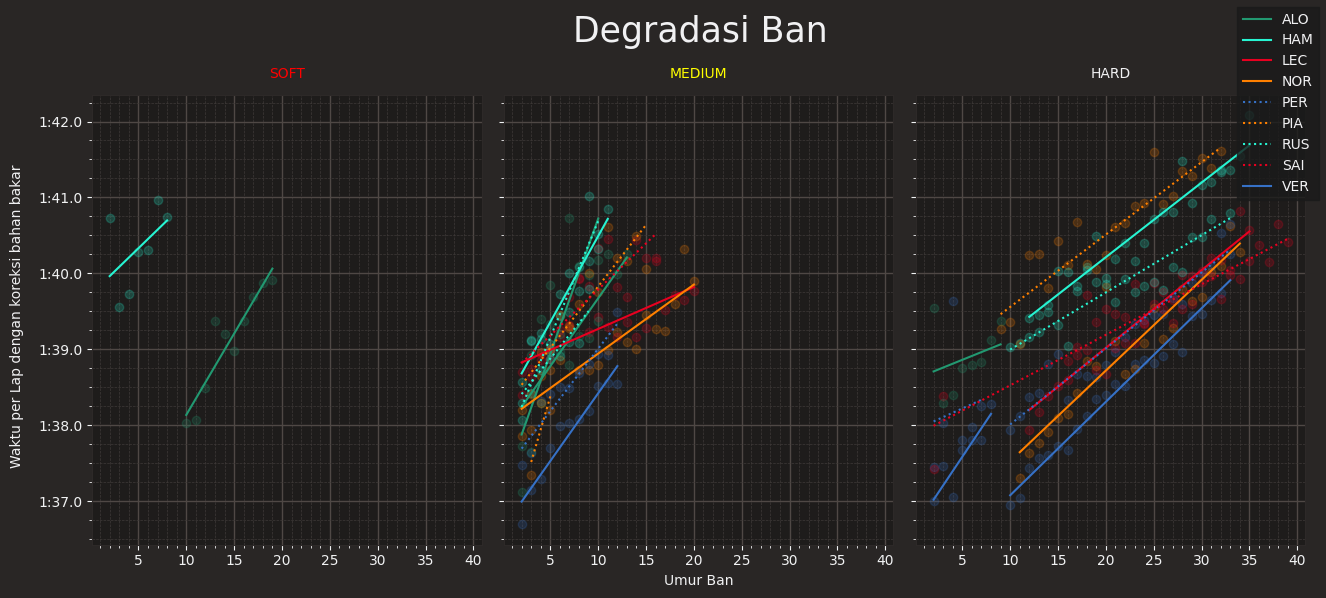

In [ ]:
#menghitung degradasi ban tiap jenis menurut unmur ban

import datetime
pits=china2024_r.laps.pick_drivers(['NOR','LEC','VER','ALO','RUS','PER','SAI','PIA','HAM']).dropna(subset='PitInTime')[china2024_r.laps['LapNumber']>1][['Driver','DriverNumber','LapNumber','Team']]

fig,ax=plt.subplots(1,3,sharey=True,sharex=True,figsize=(13,6))
for i,row in laps_corrected[(laps_corrected['LapNumber']>1) & (laps_corrected['IsAccurate']==True) &(laps_corrected['LapTime']<timedelta(minutes=2,seconds=0)) & (laps_corrected['Driver'].isin(['NOR','LEC','VER','ALO','RUS','PER','SAI','PIA','HAM']))].iterrows():
    if row['Compound']=='SOFT':
        ax[0].scatter(row['TyreLife'],row['fuel_corrected_laptime'],color='#'+china2024_r.get_driver(row['DriverNumber']).TeamColor,alpha=0.2)
    if row['Compound']=='HARD':
        ax[2].scatter(row['TyreLife'],row['fuel_corrected_laptime'],color='#'+china2024_r.get_driver(row['DriverNumber']).TeamColor,alpha=0.2)
    if row['Compound']=='MEDIUM':
        ax[1].scatter(row['TyreLife'],row['fuel_corrected_laptime'],color='#'+china2024_r.get_driver(row['DriverNumber']).TeamColor,alpha=0.2)
ax[0].set_title('SOFT',color='red',fontsize=10)
ax[1].set_xlabel('Umur Ban')
fig.text(-.01,0.23,'Waktu per Lap dengan koreksi bahan bakar',rotation=90)
ax[1].set_title('MEDIUM',color='yellow',fontsize=10)
ax[2].set_title('HARD',fontsize=10)
dfTeamNum=pd.DataFrame(laps_corrected)[['Driver','Team','DriverNumber']].drop_duplicates().set_index('Driver').groupby('Team').rank().reset_index()
laps_corrected_plus=dfTeamNum.rename(columns={'DriverNumber':'TeamNum'}).merge(laps_corrected, on='Driver')
stintgroups=laps_corrected_plus[(laps_corrected_plus['LapNumber']>1) & (laps_corrected_plus['IsAccurate']==True) &(laps_corrected_plus['LapTime']<timedelta(minutes=2,seconds=0)) & (laps_corrected_plus['Driver'].isin(['NOR','LEC','VER','ALO','RUS','PER','SAI','PIA','HAM']))][['Stint','Compound','fuel_corrected_laptime','LapNumber','Driver','Team','TeamNum','TyreLife']].groupby(['Compound','Driver','Stint','Team','TeamNum'])
drvCache=[]
for i,group in stintgroups:
    if i[1] in drvCache:
        labelVar=''
    else:
        labelVar=i[1]
        drvCache.append(i[1])
    if i[4]==1:
        linestyleVar='-'
    else:
        linestyleVar=':'
   # xx = np.linspace(min(group['fuel_corrected_laptime']),max(group['fuel_corrected_laptime']), 100)
    y = group['fuel_corrected_laptime'].apply(lambda x: x.total_seconds())
    a, b = np.polyfit(group['TyreLife'],y, 1)

    
    if i[0]=='MEDIUM':
        ax[1].plot(group['TyreLife'], pd.Series(a*group['TyreLife']+b).apply(lambda x: datetime.timedelta(seconds=x)),color='#'+china2024_r.get_driver(i[1]).TeamColor,linestyle=linestyleVar,label=labelVar)
    if i[0]=='HARD':
        ax[2].plot(group['TyreLife'], pd.Series(a*group['TyreLife']+b).apply(lambda x: datetime.timedelta(seconds=x)),color='#'+china2024_r.get_driver(i[1]).TeamColor,linestyle=linestyleVar,label=labelVar)
    if i[0]=='SOFT':
        ax[0].plot(group['TyreLife'], pd.Series(a*group['TyreLife']+b).apply(lambda x: datetime.timedelta(seconds=x)),color='#'+china2024_r.get_driver(i[1]).TeamColor,linestyle=linestyleVar,label=labelVar)
        
fig.suptitle('     Degradasi Ban',fontsize=25)

fig.tight_layout()
fig.legend()

plt.show()


<ul>
<li>
Mercedes memiliki tingkat degradasi ban yang sangat tinggi, terutama pada Hamilton
</li>
<li>
Norris berhasil mempertahankan ban mediumnya, dengan pace yang hampir sama dengan Leclerc pada ban Medium
</li>
<li>
Strategi Alonso menggunakan ban soft untuk membuat lawannya kaget tidak berhasil, karena pace Alonso di ban soft tidak cukup cepat dibandingkan dengan pace leader lainnya yang bahkan menggunakan Hard
</li>
<li>
Lagi - lagi Ferrari menunjukkan kekuatannya yaitu degradasi ban yang rendah, sangat terlihat oleh Sainz yang pit stop sebelum SC dan tidak melakukan pit stop lagi sampai akhir balapan
</li>
</ul>

<p>

<H3><strong>Recap:</strong></H3>

<li>
Periode Safety Car yang lumayan lama (5+5 Laps) sangat berpengaruh pada dinamika balapan ini. Mulai dari perubahan strategi pit stop, hingga kekacauan saat restart sangat berkontribusi.
</li>
<li>
Ferrari memiliki efisiensi ban yang sangat tinggi, tetapi McLaren mulai dapat menandingi efiensi ban Ferrari.
</li>
<li>
Persaingan antara Mercedes dengan Aston Martin secara teknis ditentukan oleh Top Speed dan Degradasi ban, dan Mercedes terlihat kesulitan dalam menangani degradasi ini.
</li>
<li>
Norris sangat cepat, lebih cepat dari Perez, tapi masih jauh dari Verstappen.
</li>